<a href="https://colab.research.google.com/github/kartik10sharma/cv_prj/blob/main/Smile_detection-Yawn_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2


bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


smile data for p61 is used


Detected 20 smile events with dynamic threshold = 51.33 (k=1.5)


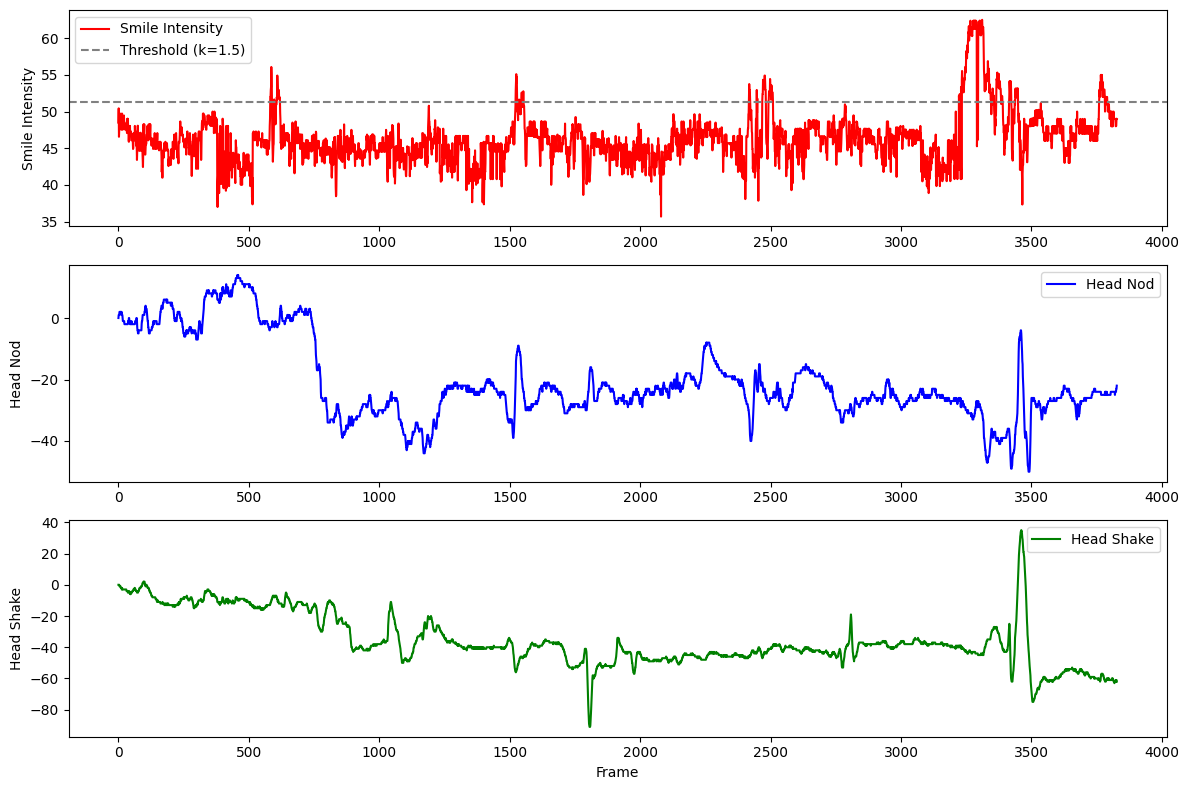

Statistics saved to smile_stats_video.csv


In [3]:
import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Initialize video capture
video_path = '/content/P61.avi'
cap = cv2.VideoCapture(video_path)

smile_intensity_list = []
head_nod_list = []
head_shake_list = []

frame_num = 0
initial_nose_y = None
initial_nose_x = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Smile Intensity: Distance between mouth corners
        left = np.array([landmarks.part(48).x, landmarks.part(48).y])
        right = np.array([landmarks.part(54).x, landmarks.part(54).y])
        smile_intensity = np.linalg.norm(right - left)
        smile_intensity_list.append(smile_intensity)

        # Head nod/shake: Nose tip movement (point 30)
        nose = np.array([landmarks.part(30).x, landmarks.part(30).y])

        if initial_nose_y is None:
            initial_nose_y = nose[1]
            initial_nose_x = nose[0]

        head_nod_list.append(nose[1] - initial_nose_y)
        head_shake_list.append(nose[0] - initial_nose_x)

        break  # Analyze only first detected face

    frame_num += 1

cap.release()
cv2.destroyAllWindows()

# Convert to NumPy arrays
smile_intensity = np.array(smile_intensity_list)
head_nod = np.array(head_nod_list)
head_shake = np.array(head_shake_list)

# Set k value for thresholding
k = 1.  # You can tune this value
dynamic_threshold = smile_intensity.mean() + k * smile_intensity.std()

# Function for smile event detection
def detect_smile_events(smile_data, threshold, min_duration=2):
    events = []
    in_smile = False
    start = 0
    for i, val in enumerate(smile_data):
        if not in_smile and val > threshold:
            in_smile = True
            start = i
        elif in_smile and val <= threshold:
            in_smile = False
            if i - start >= min_duration:
                events.append((start, i-1))
    return events

# Detect smile events using dynamic threshold
events = detect_smile_events(smile_intensity, dynamic_threshold)
print(f"Detected {len(events)} smile events with dynamic threshold = {dynamic_threshold:.2f} (k={k})")

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(smile_intensity, color='red', label='Smile Intensity')
plt.axhline(y=dynamic_threshold, color='gray', linestyle='--', label=f'Threshold (k={k})')
plt.ylabel('Smile Intensity')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(head_nod, color='blue', label='Head Nod')
plt.ylabel('Head Nod')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(head_shake, color='green', label='Head Shake')
plt.xlabel('Frame')
plt.ylabel('Head Shake')
plt.legend()

plt.tight_layout()
plt.show()

# Save stats
stats = {
    'mean': [smile_intensity.mean()],
    'std': [smile_intensity.std()],
    'max': [smile_intensity.max()],
    'min': [smile_intensity.min()],
    'num_events': [len(events)],
    'threshold': [dynamic_threshold]
}
stats_df = pd.DataFrame(stats)
stats_df.to_csv('smile_stats_video.csv', index=False)
print("Statistics saved to smile_stats_video.csv")


Yawning


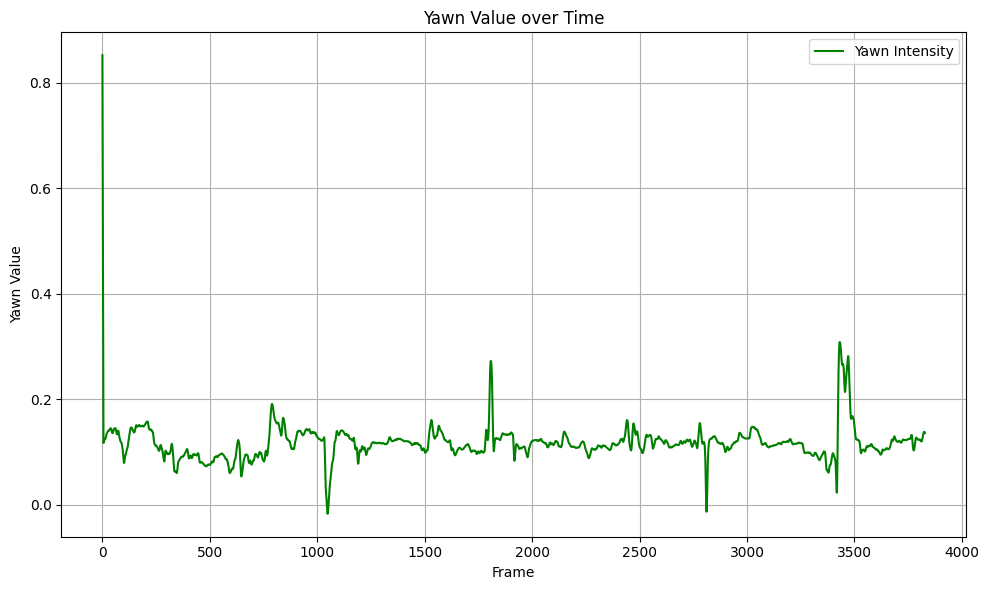

Detected 1 yawn events above threshold.
 yawn statistics saved to yawn_stats.csv


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data
file_path = '/content/P61.csv'  # Update path if needed
df = pd.read_csv(file_path, sep=',', header=None)

# 2. Extract the yawn column
yawn = df.iloc[1:, 1].astype(float)

# 3. Plot the yawn values
plt.figure(figsize=(10, 6))
plt.plot(yawn, color='green', label='Yawn Intensity')
plt.xlabel('Frame')
plt.ylabel('Yawn Value')
plt.title('Yawn Value over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Detect yawn events (threshold based)
def detect_yawn_events(yawn_series, threshold=0.4, min_duration=3):
    events = []
    in_yawn = False
    start = 0
    for i, val in enumerate(yawn_series):
        if not in_yawn and val > threshold:
            in_yawn = True
            start = i
        elif in_yawn and val <= threshold:
            in_yawn = False
            if i - start >= min_duration:
                events.append((start, i-1))
    return events

# 5. Detect and report yawn events
yawn_events = detect_yawn_events(yawn)
print(f"Detected {len(yawn_events)} yawn events above threshold.")

# 6. Save simple yawn stats
stats = {
    'mean_yawn': [yawn.mean()],
    'std_yawn': [yawn.std()],
    'max_yawn': [yawn.max()],
    'min_yawn': [yawn.min()],
    'num_yawn_events': [len(yawn_events)]
}
pd.DataFrame(stats).to_csv('yawn_stats.csv', index=False)
print(" yawn statistics saved to yawn_stats.csv")


Batch Process of yawning

Detected 1 yawn events with dynamic threshold = 8.41 (k=4)


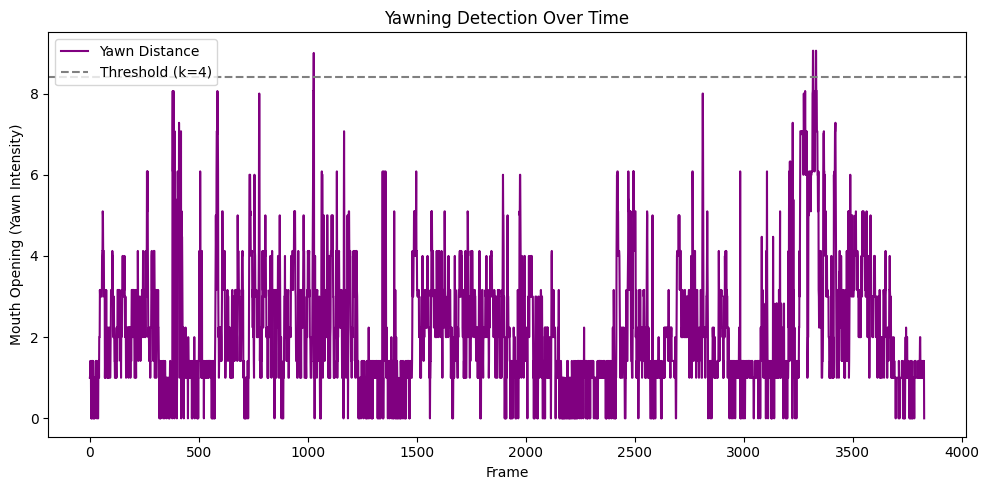

Statistics saved to yawn_stats_video.csv


In [12]:
import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Load video
video_path = '/content/P61.avi'
cap = cv2.VideoCapture(video_path)

yawn_distances = []
frame_num = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)

        # Yawn distance: distance between upper and lower inner lips (points 62 & 66)
        upper_lip = np.array([landmarks.part(62).x, landmarks.part(62).y])
        lower_lip = np.array([landmarks.part(66).x, landmarks.part(66).y])
        yawn_distance = np.linalg.norm(upper_lip - lower_lip)
        yawn_distances.append(yawn_distance)

        break  # Process only one face

    frame_num += 1

cap.release()
cv2.destroyAllWindows()

# Convert to numpy array
yawn_distances = np.array(yawn_distances)

# Dynamic thresholding using mean + k * std
k = 4 # You can tune this value
dynamic_threshold = yawn_distances.mean() + k * yawn_distances.std()

# Detect yawn events
def detect_yawn_events(data, threshold, min_duration=2):
    events = []
    in_yawn = False
    start = 0
    for i, val in enumerate(data):
        if not in_yawn and val > threshold:
            in_yawn = True
            start = i
        elif in_yawn and val <= threshold:
            in_yawn = False
            if i - start >= min_duration:
                events.append((start, i - 1))
    return events

yawn_events = detect_yawn_events(yawn_distances, dynamic_threshold)
print(f"Detected {len(yawn_events)} yawn events with dynamic threshold = {dynamic_threshold:.2f} (k={k})")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(yawn_distances, label='Yawn Distance', color='purple')
plt.axhline(y=dynamic_threshold, color='gray', linestyle='--', label=f'Threshold (k={k})')
plt.title('Yawning Detection Over Time')
plt.xlabel('Frame')
plt.ylabel('Mouth Opening (Yawn Intensity)')
plt.legend()
plt.tight_layout()
plt.show()

# Save stats
stats = {
    'mean': [yawn_distances.mean()],
    'std': [yawn_distances.std()],
    'max': [yawn_distances.max()],
    'min': [yawn_distances.min()],
    'num_events': [len(yawn_events)],
    'threshold': [dynamic_threshold]
}
stats_df = pd.DataFrame(stats)
stats_df.to_csv('yawn_stats_video.csv', index=False)
print("Statistics saved to yawn_stats_video.csv")
